# Testing state abstraction of Ott's data

While we aim to collect a whole new data set for this project, we can nontheless test whether our state abstraction model of existing data. The design we aim to use is adapted Ott et al.'s design. For our purpose, we will increase the number of states compared to the original, to make it more difficult for participants to solve the MDP to push them to resort to abstraction. Therefore, the original design is not necessarily geared toward state abstraction. Nonetheless, participants were observed to behave suboptimally in the original design, which might indicate that already the state space size of the original study might be too large for participants to deal with. We can therefore test our state abstraction model on these data. First, we will compute the pairwise distances of each states in the original state space, generate abstracted MDP at various $\epsilon$ levels ($\epsilon=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]$) and compare the results of that model to the model from Ott et al.

## Compute pairwise distances:

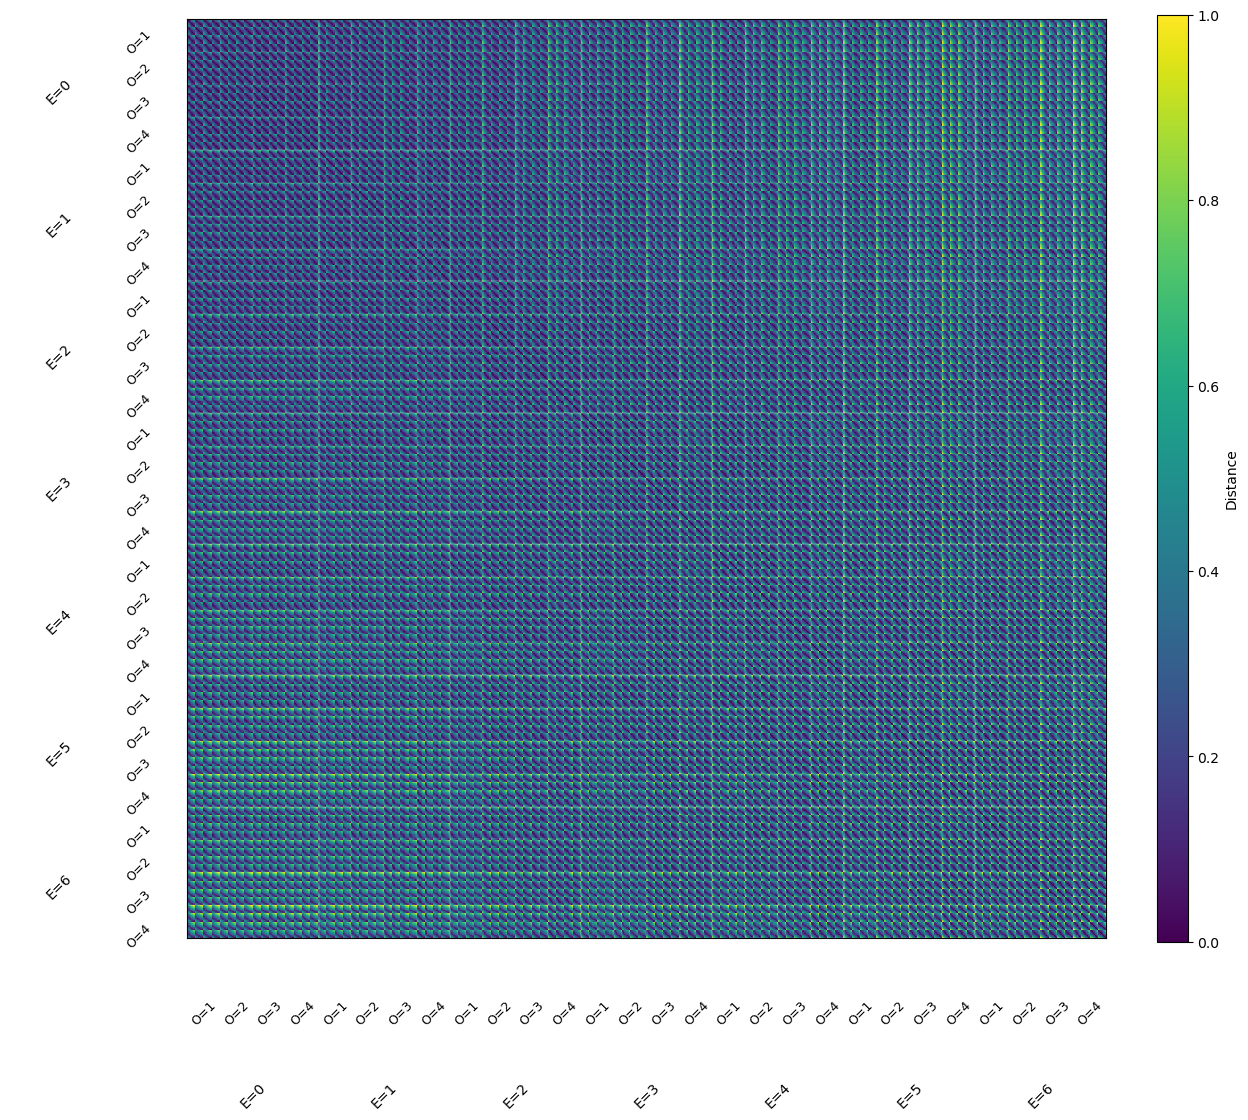

In [1]:
import numpy as np
import pandas as pd
import os
from scipy.stats import zscore
from stabst.utils import plot_state_matrix, state_classes_from_lbl, avg_reduce_mdp, abstract2ground_value
from scipy.special import expit
from stabst.MarkovDecisionProcess import MDP
from stabst.TaskConfig import LimitedEnergyTask
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import arviz as az
import pymc as pm

# Create the task and its parameters (transition probability, reward...):
task = LimitedEnergyTask(O=[1, 2, 3, 4], p_offer=[1/4] * 4)
task.build()

# Create full MDP and compute solution for later reference:
task_mdp = MDP(task.states, task.tp, task.r, s2i=task.s2i)
V_full, Q_full = task_mdp.backward_induction()
R_full = task_mdp.expected_return(task_mdp.greedy_policy(Q_full), initial_energy=3)

# Compute pairwise distances:
if not os.path.isfile('distance_matrix_ott.npy'):
    distances_matrix = task_mdp.qdist(Q_full)
    distances_matrix = distances_matrix / np.max(distances_matrix)
    if not os.path.isdir("../data/bids/limited_energy/derivatives/state_abstraction"):
        os.makedirs("../data/bids/limited_energy/derivatives/state_abstraction")
    np.save('../data/bids/limited_energy/derivatives/state_abstraction/bisimulation_distance_matrix.npy', distances_matrix)
else:
    distances_matrix = np.load('../data/bids/limited_energy/derivatives/state_abstraction/bisimulation_distance_matrix.npy')

# Plot the distance matrix:
plot_state_matrix(distances_matrix, task.states, feature_names=["E", "O", "CC", "FC", "T"], depth=2)
plt.show()

# Compute decision values for each abstraction level:

In [2]:
unique_dist = np.unique(np.round(distances_matrix, decimals=3))
abstraction_return = []
mdp_size = []
for eps in unique_dist: #unique_dist:
    # Generate abstracted MDP at that level of abstraction:
    abstract_mdp, state_classes, class_of_state = task_mdp.distance_reduce_mdp(eps, distance_matrix=distances_matrix)
    mdp_size.append(len(abstract_mdp.states))
    # Solve the MDP:
    V_R, Q_R = abstract_mdp.backward_induction()
    # Project back to Ground space:
    V_from_abstract, Q_from_abstract = abstract2ground_value(class_of_state, V_R, Q_R)
    abstraction_return.append(task_mdp.expected_return(task_mdp.greedy_policy(Q_from_abstract), initial_energy=3))

# Extract the 20 best abstraction levels:
abstraction_levels = unique_dist[np.argsort([-val for val in abstraction_return])][:20]
DVs = []
for eps in abstraction_levels:
    # Abstraction of 0 = no abstraction
    if eps == 0:
        DVs.append(Q_full[:, 1] - Q_full[:, 0])
    else:
        # Find states clusters
        states_lbl = AgglomerativeClustering(distance_threshold=eps, 
                                            n_clusters=None, linkage='complete', metric='precomputed').fit(distances_matrix).labels_
        # Create state classes:
        state_classes = state_classes_from_lbl(task.states, states_lbl)
        # Reduce the MDP accordingly:
        statesR, tpR, rR, class_of_state = avg_reduce_mdp(state_classes, task_mdp.tp, task_mdp.r, task_mdp.s2i)
        # Create reduced MDP:
        task_mdp_reduced = MDP(statesR, tpR, rR)
        # Solve the MDP:
        V_R, Q_R = task_mdp_reduced.backward_induction()
        # Project back to full space:
        V_from_reduced, Q_from_reduced = abstract2ground_value(class_of_state, V_R, Q_R)
        # Add to decision values
        DVs.append(zscore(Q_from_reduced[:, 1] - Q_from_reduced[:, 0]))

## Prepare data for model fitting:

C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_7296\1188538962.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if i > 10 and row[0] == 0:


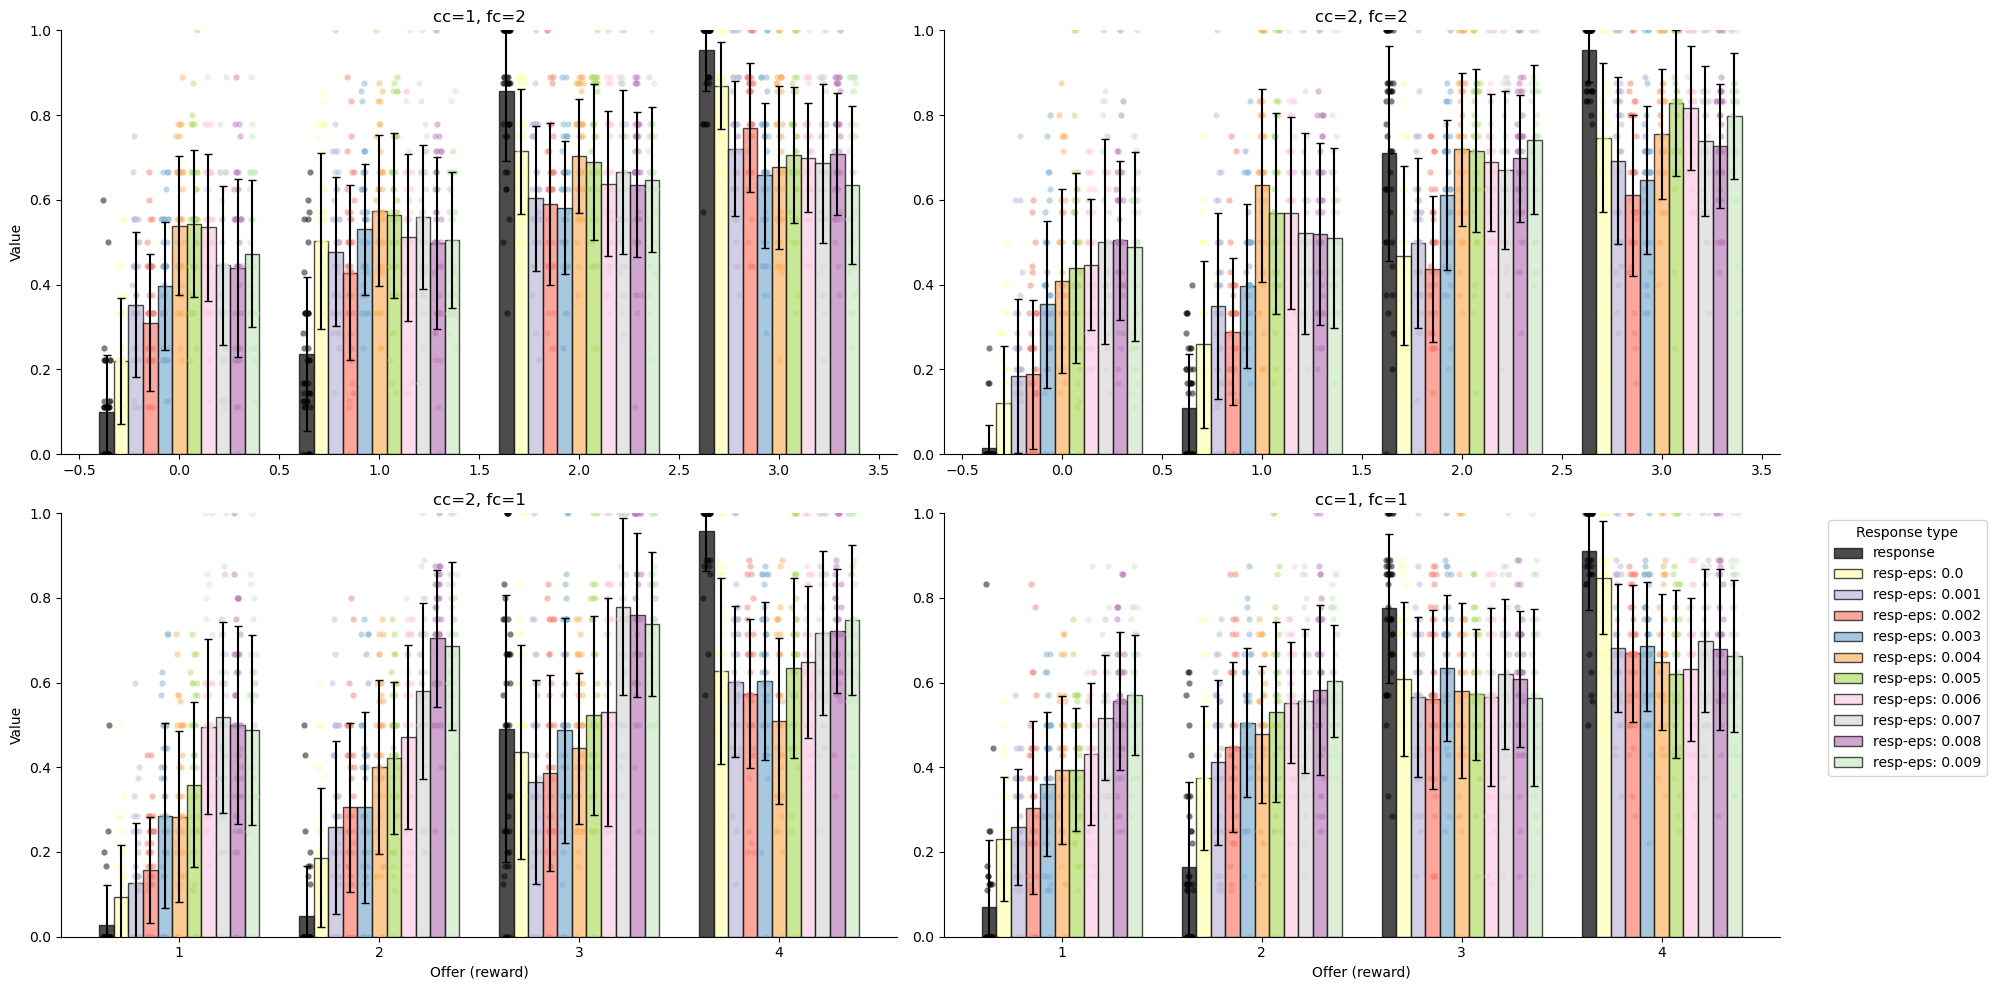

In [3]:
# Download data from Florian's repo:
data = pd.read_csv(r"..\data\raw_data\all_participants_data.csv", on_bad_lines='skip')
# Remove nans:
data = data.dropna()
# Flip responses: 1 = accept:
data["response"] = np.abs(data["response"] - 1)
# Remove trials with max energy or too low energy:
data = data[data["energy"] != 6].reset_index(drop=True)
data = data[data["energy"] >= data["energy_cost"]].reset_index(drop=True)
# Add a subject column:
sub_id = 1
for i, row in data.iterrows():
    if i > 10 and row[0] == 0:
        sub_id += 1
    data.at[i, 'subject'] = f'sub-{sub_id}'
# Remove the 
# Get subject IDs:
subj_idx_raw, subj_labels = pd.factorize(data["subject"])
coords = {
    "observation": np.arange(len(data)),
    "subject": subj_labels,
}

transitions_costs = {
    0: [1, 1],
    1: [2, 1],
    2: [1, 2],
    3: [2, 2]
}
# Add the decision value associated with each epsilons:
for eps_i, eps in enumerate(abstraction_levels):
    # Get the decision value:
    dv = DVs[eps_i]
    # Loop through each trial to set DV:
    dv_trials = []
    mdl_sim_resps = []
    decision_match = []
    for trial_i, trial in data.iterrows():
        e, o, cc, t = trial.energy, trial.reward, trial.energy_cost, trial.trial
        fc = transitions_costs[trial.transition][1]
        dv_trials.append(dv[task.s2i[(e, o, cc, fc, t+1)]])
        # Simulate data according to that plan:
        mdl_sim_resps.append(np.random.binomial(1, expit(dv[task.s2i[(e, o, cc, fc, t+1)]])))
        decision_match.append(1 - np.abs(trial.response - mdl_sim_resps[-1]))
    data[f'DV-eps: {eps}'] = dv_trials
    data[f'resp-eps: {eps}'] = mdl_sim_resps
    data[f'decision_match-eps: {eps}'] = decision_match

# Plot the results:
fig, ax = plt.subplots(2, 2, figsize=[20, 10])
import matplotlib
cmap = matplotlib.colormaps.get_cmap('Set3')
ax = ax.flatten()
for i, trans in enumerate(data['transition'].unique()):
    results = data[data['transition'] == trans].groupby(['subject', 'reward'])[['response', *[f'resp-eps: {eps}' for eps in abstraction_levels[0:10]]]].mean().reset_index()
    resp_cols = [c for c in results.columns if c.startswith('resp-eps') or c == 'response']
    rewards = np.sort(results['reward'].unique())

    n_rewards = len(rewards)
    n_resp = len(resp_cols)

    x = np.arange(n_rewards)  # base positions per reward/offer
    bar_width = 0.8 / n_resp  # so each group takes ~0.8 width

    # precompute stats
    grouped = results.groupby('reward')[resp_cols]

    means = grouped.mean()
    stds = grouped.std()

    for j, col in enumerate(resp_cols):
        # horizontal offset for this response-type within each reward group
        offset = (j - (n_resp - 1) / 2) * bar_width
        
        # bar positions
        x_pos = x + offset
        
        # get mean and std aligned with rewards
        m = means[col].reindex(rewards).values
        s = stds[col].reindex(rewards).values

        # bars: mean + std
        if col == 'response':
            color = 'k'
        else:
            color = cmap(j)
        try:
            ax[i].bar(
                x_pos,
                m,
                bar_width,
                yerr=s,
                capsize=3,
                alpha=0.7,
                label=col,
                color=color,
                edgecolor='k',
                linewidth=1
            )
        except:
            print('A')

        # overlay per-subject "cloud" for this response-type
        for ii, r in enumerate(rewards):
            vals = results.loc[results['reward'] == r, col].values
            # jitter around the bar center
            jitter = np.random.uniform(-bar_width / 4, bar_width / 4, size=len(vals))
            ax[i].scatter(
                np.full_like(vals, x_pos[ii]) + jitter,
                vals,
                color=color,
                s=20,
                alpha=0.5,
                edgecolors='k',
                linewidths=0.0
            )

    # cosmetic stuff
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_ylim([0, 1])
    if i > 1:
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(rewards)
        ax[i].set_xlabel('Offer (reward)')
    if i == 0 or i == 2:
        ax[i].set_ylabel('Value')
    ax[i].set_title(f'cc={transitions_costs[trans][0]}, fc={transitions_costs[trans][1]}')
    if i == len(ax) -1:
        ax[i].legend(title='Response type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_7296\4132473836.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('Set3')


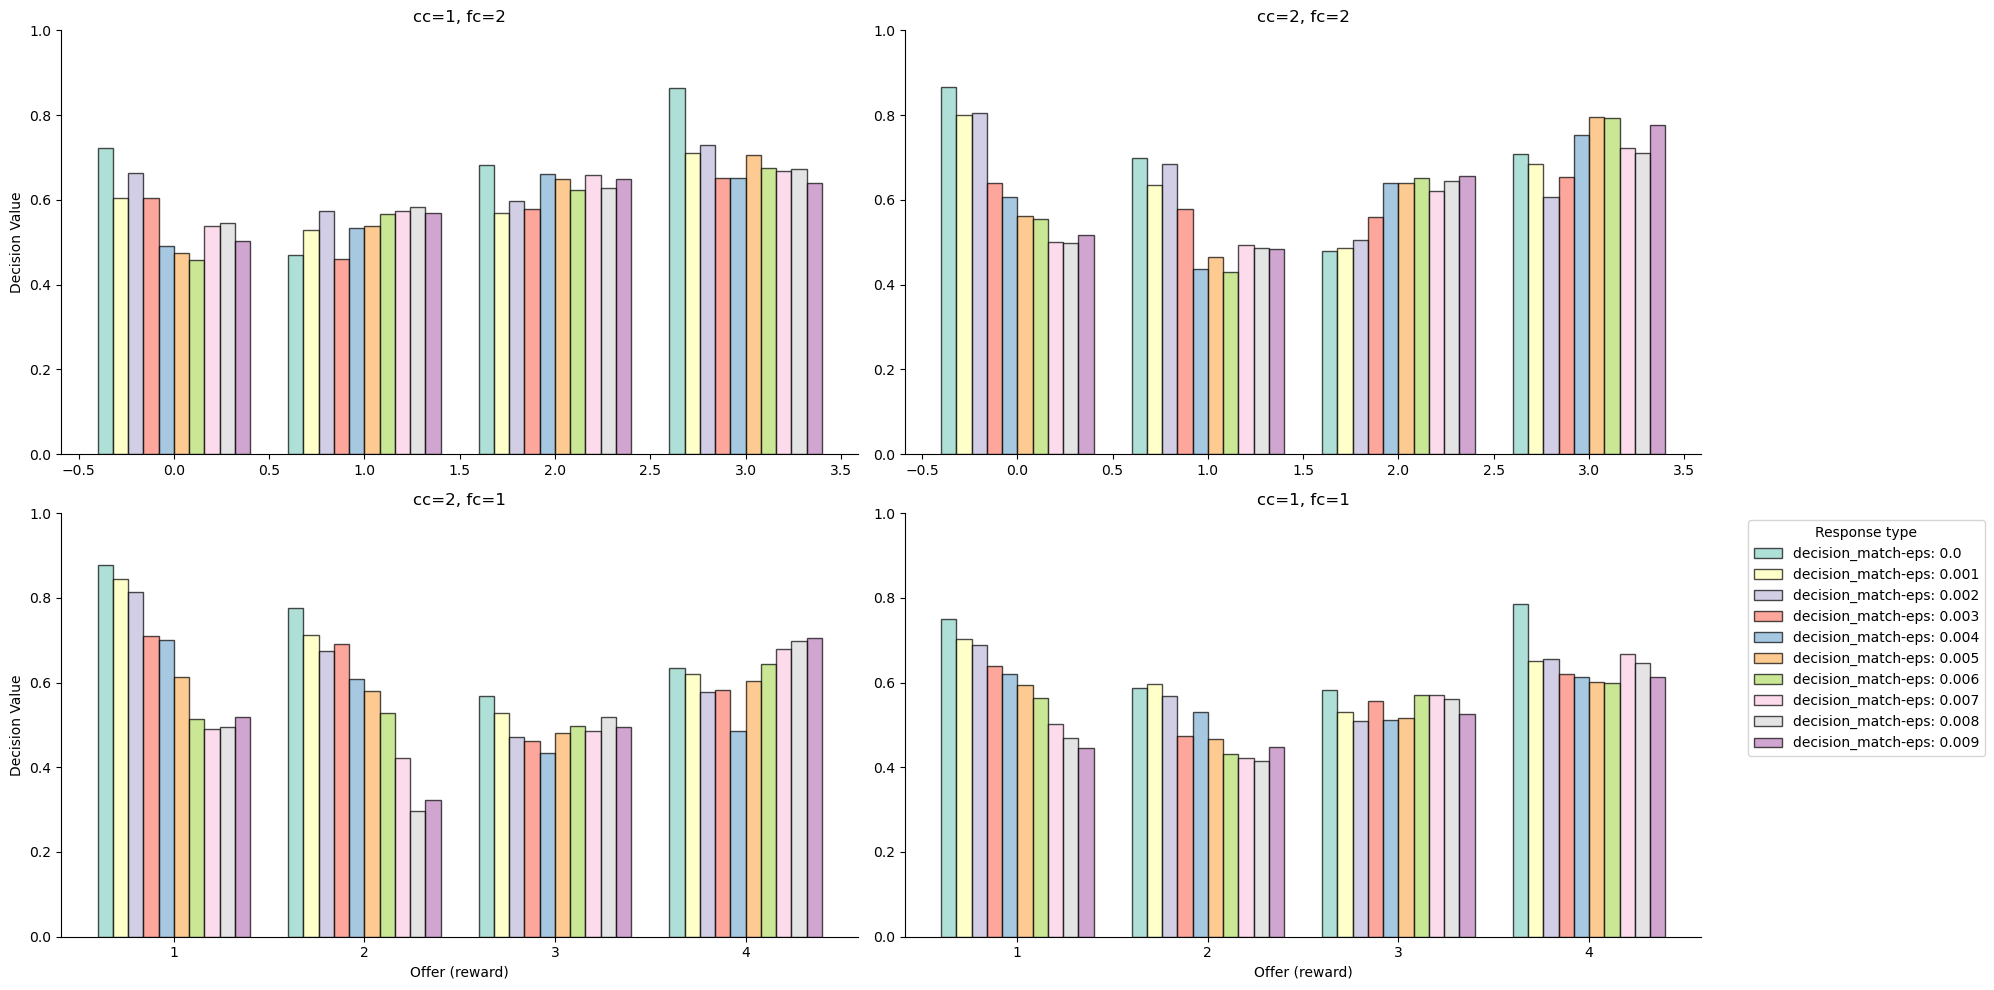

In [ ]:
# Plot the difference between each models prediction and participants behaviour:
# Plot the results:
fig, ax = plt.subplots(2, 2, figsize=[20, 10])
import matplotlib
cmap = matplotlib.cm.get_cmap('Set3')
ax = ax.flatten()
for i, trans in enumerate(data['transition'].unique()):
    results = data[data['transition'] == trans].groupby(['subject', 'reward'])[[f'decision_match-eps: {eps}' for eps in abstraction_levels[0:10]]].mean().reset_index()
    resp_cols = [c for c in results.columns if c.startswith('decision_match')]
    rewards = np.sort(results['reward'].unique())

    n_rewards = len(rewards)
    n_resp = len(resp_cols)

    x = np.arange(n_rewards)  # base positions per reward/offer
    bar_width = 0.8 / n_resp  # so each group takes ~0.8 width

    # precompute stats
    grouped = results.groupby('reward')[resp_cols]

    means = grouped.mean()
    stds = grouped.std()

    for j, col in enumerate(resp_cols):
        # horizontal offset for this response-type within each reward group
        offset = (j - (n_resp - 1) / 2) * bar_width
        
        # bar positions
        x_pos = x + offset
        
        # get mean and std aligned with rewards
        m = means[col].reindex(rewards).values
        s = stds[col].reindex(rewards).values

        # bars: mean + std
        if col == 'response':
            color = 'k'
        else:
            color = cmap(j)
        ax[i].bar(
            x_pos,
            m,
            bar_width,
            capsize=3,
            alpha=0.7,
            label=col,
            color=color,
            edgecolor='k',
            linewidth=1
        )

    # cosmetic stuff
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_ylim([0, 1])
    if i > 1:
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(rewards)
        ax[i].set_xlabel('Offer (reward)')
    if i == 0 or i == 2:
        ax[i].set_ylabel('Match between predicted and observed')
    ax[i].set_title(f'cc={transitions_costs[trans][0]}, fc={transitions_costs[trans][1]}')
    if i == len(ax) -1:
        ax[i].legend(title='Response type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [5]:
import seaborn as sns
with pm.Model(coords=coords) as binomial_regression_model:
    x = pm.Data("DV", data[f'DV-eps: {abstraction_levels[3]}'], dims="observation")  # Continuous: Decision value from dynamic programming model
    subj_idx = pm.Data("subj_idx", subj_idx_raw, dims="observation")
    # Hyperpriors
    mu_b0 = pm.Normal('mu_b0', mu=0, sigma=2)
    sigma_b0 = pm.HalfNormal('sigma_b0', sigma=2)
    mu_b1 = pm.Normal('mu_b1', mu=0, sigma=2)
    sigma_b1= pm.HalfNormal('sigma_b1', sigma=2)
    # Intercept for each subject, distributed around group mean mu_b0
    b0_offset = pm.Normal('beta0_offset', mu=0, sigma=1, dims="subject")
    b0 = pm.Deterministic("beta0", mu_b0 + b0_offset * sigma_b0)
    # Intercept for each subject, distributed around group mean mu_b1
    b1_offset = pm.Normal('beta1_offset', mu=0, sigma=1, dims="subject")
    b1 = pm.Deterministic("beta1", mu_b1 + b1_offset * sigma_b1)
    
    # Expected value
    mu = b0[subj_idx] + b1[subj_idx] * x
    pm.Bernoulli("y", logit_p=mu, observed=data["response"], dims="observation")
with binomial_regression_model:
    idata =  pm.sample(1000, tune=1000, target_acceptance=0.95, idata_kwargs={"log_likelihood": True})


c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


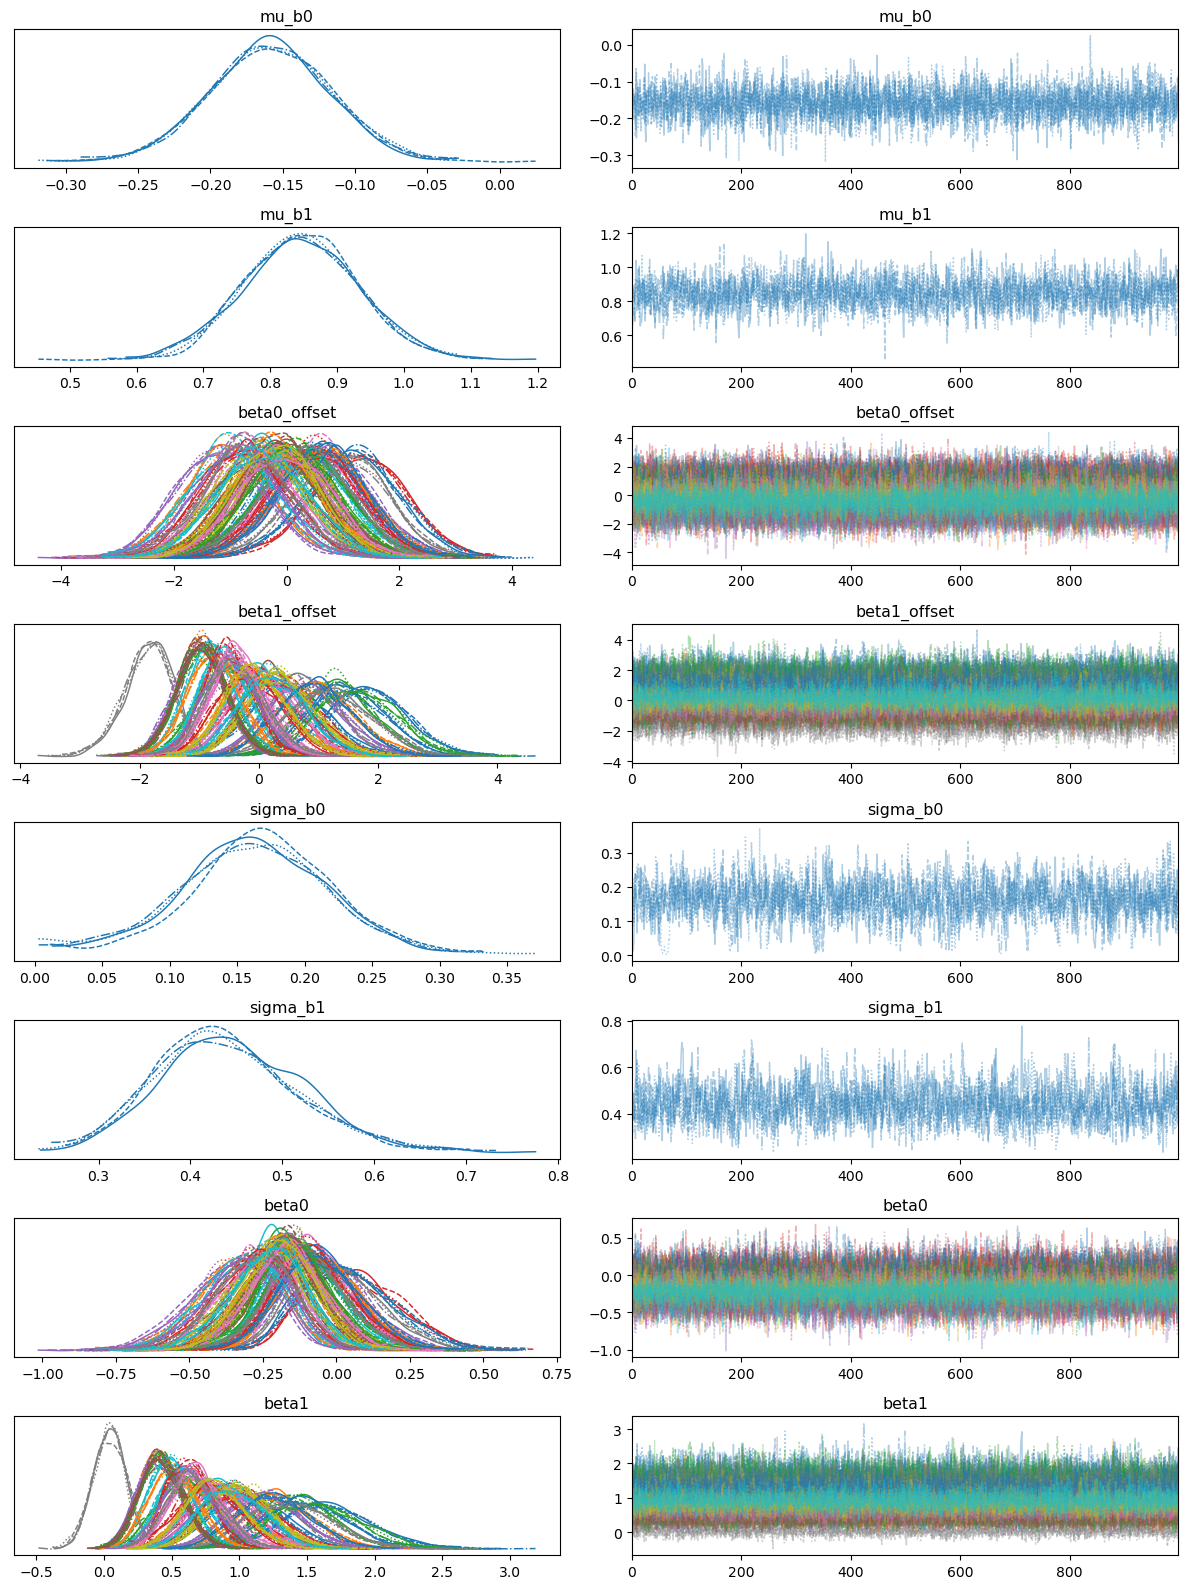

In [6]:
az.plot_trace(idata);
plt.tight_layout()

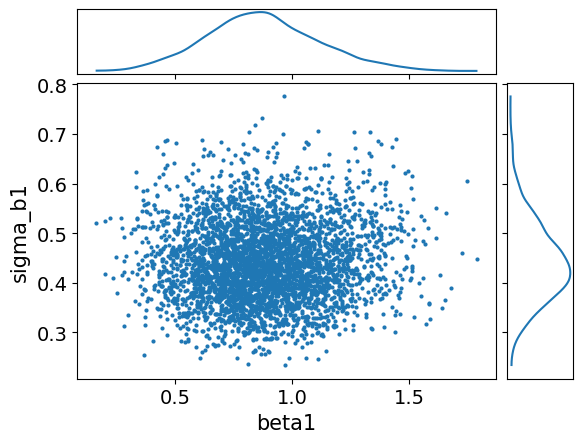

In [7]:
az.plot_pair(
    idata,
    group='posterior',
    var_names=["beta1", "sigma_b1"],
    coords={"beta1_dim_0": 3},   # pick subject 75
    kind="scatter",
    divergences=True,
    marginals=True
);

In [8]:
az.summary(idata, var_names=["mu_b0", "mu_b1", "beta0", "beta1"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_b0     -0.159  0.042  -0.239   -0.081      0.001    0.001    4515.0   
mu_b1      0.846  0.085   0.694    1.015      0.002    0.001    2074.0   
beta0[0]  -0.108  0.136  -0.356    0.153      0.002    0.002    6606.0   
beta0[1]  -0.332  0.140  -0.587   -0.072      0.002    0.002    3354.0   
beta0[2]  -0.147  0.133  -0.395    0.104      0.002    0.003    6857.0   
...          ...    ...     ...      ...        ...      ...       ...   
beta1[35]  0.428  0.162   0.129    0.731      0.002    0.003    6442.0   
beta1[36]  0.675  0.183   0.344    1.028      0.002    0.003    6872.0   
beta1[37]  0.675  0.196   0.342    1.075      0.002    0.003    6730.0   
beta1[38]  0.821  0.216   0.436    1.239      0.003    0.004    7287.0   
beta1[39]  0.947  0.232   0.514    1.379      0.003    0.004    7587.0   

           ess_tail  r_hat  
mu_b0        3208.0    1.0  
mu_b1        2674.0    1.0  
beta0[0]     2950.0    1.0  
beta0[1]     2681.0    1.0  
beta0[2]     2991.0    1.0  
...             ...    ...  
beta1[35]    3071.0    1.0  
beta1[36]    3109.0    1.0  
beta1[37]    3064.0    1.0  
beta1[38]    2791.0    1.0  
beta1[39]    2919.0    1.0  

[82 rows x 9 columns]

In [9]:
traces = {}
for eps_i, eps in enumerate(abstraction_levels):
    # Model the data:
    with pm.Model(coords=coords) as binomial_regression_model:
        x = pm.Data("DV", data[f'DV-eps: {eps}'], dims="observation")  # Continuous: Decision value from dynamic programming model
        subj_idx = pm.Data("subj_idx", subj_idx_raw, dims="observation")
        # Hyperpriors
        mu_b0 = pm.Normal('mu_b0', mu=0, sigma=2)
        sigma_b0 = pm.HalfNormal('sigma_b0', sigma=2)
        mu_b1 = pm.Normal('mu_b1', mu=0, sigma=2)
        sigma_b1= pm.HalfNormal('sigma_b1', sigma=2)
            
        # Intercept for each subject, distributed around group mean mu_b0
        b0_offset = pm.Normal('beta0_offset', mu=0, sigma=1, dims="subject")
        b0 = pm.Deterministic("beta0", mu_b0 + b0_offset * sigma_b0)
        # Intercept for each subject, distributed around group mean mu_b1
        b1_offset = pm.Normal('beta1_offset', mu=0, sigma=1, dims="subject")
        b1 = pm.Deterministic("beta1", mu_b1 + b1_offset * sigma_b1)
        
        # Expected value
        mu = b0[subj_idx] + b1[subj_idx] * x

        pm.Bernoulli("y", logit_p=mu, observed=data["response"], dims="observation")

        traces[f'DV, eps={eps}'] = pm.sample(1000, tune=1000, target_acceptance=0.9, idata_kwargs={"log_likelihood": True})

# Compare models:
model_comparison = az.compare(traces)

c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 103 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 105 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 106 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0_offset, beta1_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

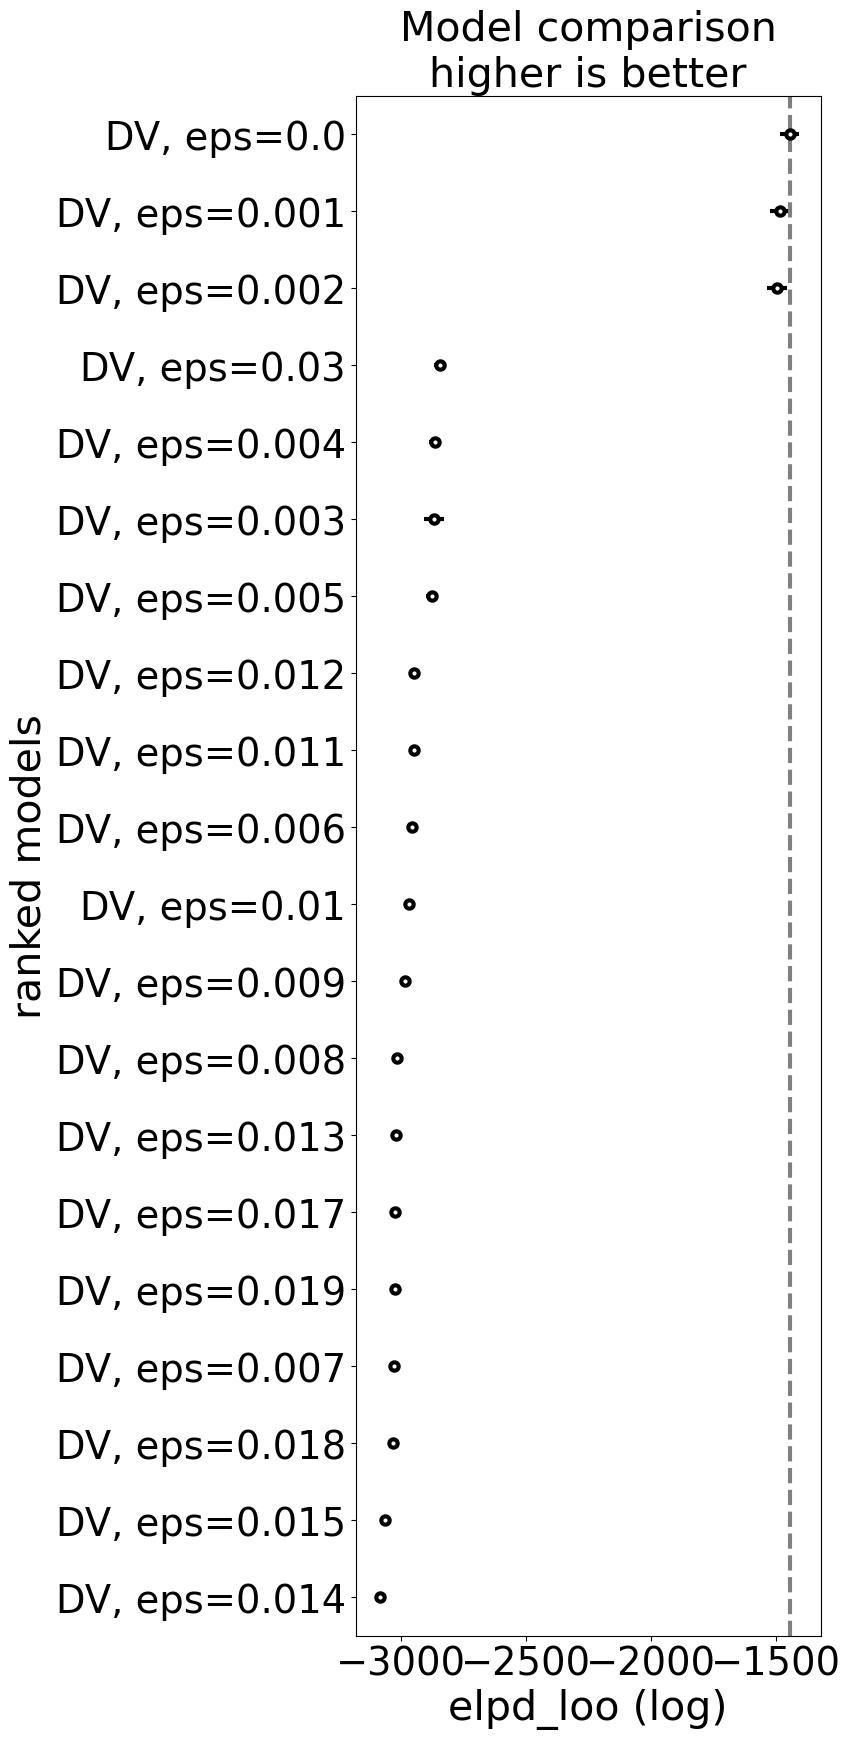

In [10]:
# Compare models:
model_comparison = az.compare(traces)
az.plot_compare(model_comparison)